In [268]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as datetime
import sys

VALOR_CAMBIO_A_DOLAR = 19.54

In [269]:
df = pd.read_csv('train.csv', index_col='id', parse_dates=['fecha'])
pd.set_option('display.float_format', '{:.2f}'.format)

In [270]:
df.columns

Index(['titulo', 'descripcion', 'tipodepropiedad', 'direccion', 'ciudad',
       'provincia', 'antiguedad', 'habitaciones', 'garages', 'banos',
       'metroscubiertos', 'metrostotales', 'idzona', 'lat', 'lng', 'fecha',
       'gimnasio', 'usosmultiples', 'piscina', 'escuelascercanas',
       'centroscomercialescercanos', 'precio'],
      dtype='object')

In [271]:
# Me quedo solo con las columnas que son importantes para nuestro analisis.
# Quizas el titulo y la descripcion tampoco las use, pero primero habria que hacer  un analisis de ese campo
df.drop(['direccion','idzona','lat','lng'], axis=1, inplace=True)

In [272]:
df.columns

Index(['titulo', 'descripcion', 'tipodepropiedad', 'ciudad', 'provincia',
       'antiguedad', 'habitaciones', 'garages', 'banos', 'metroscubiertos',
       'metrostotales', 'fecha', 'gimnasio', 'usosmultiples', 'piscina',
       'escuelascercanas', 'centroscomercialescercanos', 'precio'],
      dtype='object')

In [273]:
# 1. Ver cuantos datos (observaciones) tenemos en total
# 2. Ver cuantos atributos tiene cada observaci´on
# 3. Ver el nombre y tipo de dato de cada observaci´on
# 4. Ver cuantos valores faltantes existen y en que proporci´on se presentan para
# cada atributo
# Despues de parsear y filtrar los nulos, deberiamos poner cada columna en su tipo ideal.
# df['antiguedad'] = df['antiguedad'].astype(int)     algo de este estilo

print("Filas, columnas: ", df.shape)
print("Tipos: \n", df.dtypes)

Filas, columnas:  (240000, 18)
Tipos: 
 titulo                                object
descripcion                           object
tipodepropiedad                       object
ciudad                                object
provincia                             object
antiguedad                           float64
habitaciones                         float64
garages                              float64
banos                                float64
metroscubiertos                      float64
metrostotales                        float64
fecha                         datetime64[ns]
gimnasio                             float64
usosmultiples                        float64
piscina                              float64
escuelascercanas                     float64
centroscomercialescercanos           float64
precio                               float64
dtype: object


In [274]:
# Cosas a observar de esto:
# Propiedades sin ciudad ni provincia.
# Muchas propiedades sin metroscubiertos y totales especificados. Estas columnas son claves para 
# el precio (falta demostrar)
# 46 propiedades sin clasificacion de tipo de propiedad. 
# Habitaciones y Banos, muchos datos nulos. Sera que no tienen? Una casa no pude no tener habitacio ni bano...
# Garages, piscina, salondeusosmultiples y gimnasio son extras. Supongo que el hecho de que no aparezcan 
# es que no los tienen.
# Estos 4 extras, podrian reunirse en una categoria todas juntas para evaluar como crece el precio en base a esos
# extras.
# 43000 propiedades sin saber su antiguedad. Esto si ni idea como podemos reemplazarlos.

df.isna().sum()

titulo                         5387
descripcion                    1619
tipodepropiedad                  46
ciudad                          372
provincia                       155
antiguedad                    43555
habitaciones                  22471
garages                       37765
banos                         26221
metroscubiertos               17400
metrostotales                 51467
fecha                             0
gimnasio                          0
usosmultiples                     0
piscina                           0
escuelascercanas                  0
centroscomercialescercanos        0
precio                            0
dtype: int64

In [275]:
# Dato importante y valioso: No hay ninguna casa que no tenga especificado ni metros cubiertos ni totales
# Esto me asegura que no tengo que limpiar datos, ya que si no hubiese tenido ninguno hubiese sido dato invalido
# Conociendo uno de los dos valores, puedo intentar asumir el otro con alguna decision.
df[(df['metroscubiertos'].isnull()) & (df['metrostotales'].isnull())].head()

,titulo,descripcion,tipodepropiedad,ciudad,provincia,antiguedad,habitaciones,garages,banos,metroscubiertos,metrostotales,fecha,gimnasio,usosmultiples,piscina,escuelascercanas,centroscomercialescercanos,precio
id,,,,,,,,,,,,,,,,,,


In [276]:
# Tiene sentido que los terrenos no tengan metros cubiertos. 
# Pero como una casa, un edificio, y cualquier otra cosa que no sea un terreno no tiene metros cubiertos? 
# Y ya demostre en uno de los graficos que los metros cubiertos y totales son lo que mas influyen en el precio. 
# Esto, a mi criterio, convierte estos datos en invalidos.
df[df.metroscubiertos.isnull()]['tipodepropiedad'].value_counts()

Terreno                          6940
Casa                             6532
Terreno comercial                 851
Apartamento                       823
Edificio                          676
Casa en condominio                593
Local Comercial                   320
Bodega comercial                  293
Oficina comercial                 116
Casa uso de suelo                  99
Otros                              46
Inmuebles productivos urbanos      35
Quinta Vacacional                  13
Nave industrial                    12
Terreno industrial                  9
Villa                               7
Duplex                              5
Local en centro comercial           5
Lote                                5
Rancho                              4
Departamento Compartido             2
Name: tipodepropiedad, dtype: int64

In [277]:
# Extraigo todos aquellas propiedades que tienen metroscubiertos nulos y no son terrenos. 
# Quizas en vez de extraerlos, se podria asumir que los metros totales son todos cubiertos.
indices_invalidos = df[(df.metroscubiertos.isnull()) & (~df.tipodepropiedad.isin(['Terreno','Terreno comercial']))].index
df.drop(index=indices_invalidos, inplace=True)
df.shape

(230391, 18)

In [278]:
# No tiene sentido que una casa no tenga ciudad ni provincia, ya que son datos que influyen en el precio
# y no se pueden deducir de otro lado, ademas, son pocos
df.dropna(subset=['ciudad','provincia'], inplace=True)
df.shape

(230055, 18)

In [279]:
# Es imposible que cualquier inmueble tenga metroscubiertos, y no tenga metros totales.
# Para esos casos, le asigno la misma cantidad de metros cubiertos que totales, osea no tiene metros descubiertos.
df['metrostotales'].fillna(df['metroscubiertos'], inplace=True)

In [280]:
# Despues de estos pequeños arreglos, se reducen la cantidad de nulos. Si bien siguen habiendo, 
df.isnull().sum()

titulo                         5071
descripcion                    1484
tipodepropiedad                  19
ciudad                            0
provincia                         0
antiguedad                    41416
habitaciones                  20540
garages                       34150
banos                         23077
metroscubiertos                7777
metrostotales                     0
fecha                             0
gimnasio                          0
usosmultiples                     0
piscina                           0
escuelascercanas                  0
centroscomercialescercanos        0
precio                            0
dtype: int64

In [281]:
# El resto de filas con metros cubiertos, son terrenos. Deberian tener 0 metros cubiertos.
df['metroscubiertos'].fillna(0, inplace=True)

In [282]:
# Aquellas casas que no tienen el tipodepropiedad, son solo 19. Podria intentar sacar el tipo de prop
# desde la descripcion pero no estaria seguro al respecto. Siendo solo 19, las elimino.
df.dropna(subset=['tipodepropiedad'],inplace=True)

In [283]:
df.shape

(230036, 18)

In [284]:
# Para banos y habitaciones, completo los nulos con el promedio agrupando por tipo de propiedad y ciudad.
# En caso de que no este en ninguno de esos, le asigno el promedio por tipo de propiedad.

df['banos'] = df.groupby(['tipodepropiedad','ciudad'])['banos'].transform(lambda x: x.fillna(x.mean()))
df['habitaciones'] = df.groupby(['tipodepropiedad','ciudad'])['habitaciones'].transform(lambda x: x.fillna(x.mean()))


df['banos'] = df.groupby(['tipodepropiedad'])['banos'].transform(lambda x: x.fillna(x.mean()))
df['habitaciones'] = df.groupby(['tipodepropiedad'])['habitaciones'].transform(lambda x: x.fillna(x.mean()))

In [285]:
df.isnull().sum()

titulo                         5071
descripcion                    1483
tipodepropiedad                   0
ciudad                            0
provincia                         0
antiguedad                    41400
habitaciones                      1
garages                       34135
banos                             2
metroscubiertos                   0
metrostotales                     0
fecha                             0
gimnasio                          0
usosmultiples                     0
piscina                           0
escuelascercanas                  0
centroscomercialescercanos        0
precio                            0
dtype: int64

In [286]:
# 17964 registros sin banos ni habitaciones completados. Analizo eso:
# Hay alguno con ambos nulos?
df[(df.banos.isnull())&(df.habitaciones.isnull())].shape
# Esos 17964 coinciden.

(1, 18)

In [287]:
# Registros sin baño agrupados por tipo de propiedad.
df[df.banos.isnull()].groupby('tipodepropiedad').size()

tipodepropiedad
Garage       1
Hospedaje    1
dtype: int64

In [288]:
# Causalmente, todos esos nulos corresponden a inmuebles no habitables. Es raro suponer que no tienen baño, pero asumimos
# que ese None, es algo que no modifica el valor del inmueble. No cambia para un local su valor si tiene o no baño.
df[df.habitaciones.isnull()].groupby('tipodepropiedad').size().sum()

1

In [289]:
# La idea es ver si alguno que no sea habitable, tiene baños distinto de None para ver como reemplazar los otros nan.
# Por habitable me refiero a propiedades donde vive gente.

habitables = ['Casa','Apartamento','Casa en condominio','Casa uso de suelo','Quinta Vacacional','Villa','Duplex','Rancho','Departamento Compartido']

df[~df.tipodepropiedad.isin(habitables)]['habitaciones'].value_counts()

2.00    2596
3.00    1760
2.51    1093
1.00    1005
2.33     869
        ... 
5.40      10
2.27       9
6.40       6
5.75       5
9.20       1
Name: habitaciones, Length: 101, dtype: int64

In [290]:
# Tomo la decision de llenar los banos y habitaciones nulos, ya demostrado que corresponden a inmuebles no habitables,
# con el valor 0. Al margen de llenar los nulos, clarmaente son datos que no van a interesar para el analisis de este tipo de 
# propiedades.
df.banos.fillna(0, inplace = True)
df.habitaciones.fillna(0, inplace = True)

In [291]:
df.isnull().sum()

titulo                         5071
descripcion                    1483
tipodepropiedad                   0
ciudad                            0
provincia                         0
antiguedad                    41400
habitaciones                      0
garages                       34135
banos                             0
metroscubiertos                   0
metrostotales                     0
fecha                             0
gimnasio                          0
usosmultiples                     0
piscina                           0
escuelascercanas                  0
centroscomercialescercanos        0
precio                            0
dtype: int64

In [292]:
# Ahora voy a analizar los garages nulos. 
df[df.garages.isnull()].groupby('tipodepropiedad').size()

tipodepropiedad
Apartamento                       3543
Bodega comercial                   393
Casa                             21600
Casa en condominio                2973
Casa uso de suelo                  189
Departamento Compartido              4
Duplex                               7
Edificio                           233
Huerta                               5
Inmuebles productivos urbanos       45
Local Comercial                   1060
Local en centro comercial           42
Nave industrial                     18
Oficina comercial                  473
Otros                               48
Quinta Vacacional                  237
Rancho                              93
Terreno                           2397
Terreno comercial                  604
Terreno industrial                  17
Villa                              154
dtype: int64

In [293]:
# De aca se puede ver informacion importante: Segun la ciudad y el tipo de propiedad, varia bastante la cantidad de garages
# de una casa.
df.groupby(['tipodepropiedad','ciudad']).agg({'garages':'mean'})

garages
tipodepropiedad ciudad                        
Apartamento     Acajete                   1.00
                Acambay                   2.00
                Acapulco de Juárez        1.29
                Acateno                   1.00
                Acatzingo                  nan
...                                        ...
Villa           Tzucacab                   nan
                Veracruz                   nan
                Yautepec                  1.00
                Zapopan                   0.00
                Zihuatanejo de Azueta     0.67

[3097 rows x 1 columns]

In [294]:
# Tomo la decision de completar aquellos valores de garage nulos, con el promedio de garages para ese tipo de propiedad,
# en la ciudad en que se encuentre.
df['garages'] = df.groupby(['tipodepropiedad','ciudad'])['garages'].transform(lambda x: x.fillna(x.mean()))

In [295]:
# Para aquellos registros que registraban de promedio nan, osea ninguno tenia, los relleno con 0 como valor de garage.
df['garages'].fillna(0, inplace=True)

In [296]:
# Solo me queda revisar los nulos de antiguedad. Son muchisimos. 
df.isnull().sum()

titulo                         5071
descripcion                    1483
tipodepropiedad                   0
ciudad                            0
provincia                         0
antiguedad                    41400
habitaciones                      0
garages                           0
banos                             0
metroscubiertos                   0
metrostotales                     0
fecha                             0
gimnasio                          0
usosmultiples                     0
piscina                           0
escuelascercanas                  0
centroscomercialescercanos        0
precio                            0
dtype: int64

In [297]:
# La decision que voy a tomar para esos nulos, es similar a la de los garages. Voy a rellenar los nulos con el promedio
# de antiguedad para ese tipo de propiedad y esa ciudad en la que esta ubicada la propiedad.
# No se que tanto sentido tenga asignarle valores asi a la antiguedad porque de verdad estoy modificando de una forma que
# no necesariamente sea correcta


# df.groupby(['tipodepropiedad','ciudad']).agg({'antiguedad':'mean'})

In [298]:
# df['antiguedad'] = df.groupby(['tipodepropiedad','ciudad'])['antiguedad'].transform(lambda x: x.fillna(x.mean()))

In [299]:
df.isnull().sum()

titulo                         5071
descripcion                    1483
tipodepropiedad                   0
ciudad                            0
provincia                         0
antiguedad                    41400
habitaciones                      0
garages                           0
banos                             0
metroscubiertos                   0
metrostotales                     0
fecha                             0
gimnasio                          0
usosmultiples                     0
piscina                           0
escuelascercanas                  0
centroscomercialescercanos        0
precio                            0
dtype: int64

In [319]:
# Se puede ver mucha informacion importante aca. 
# Por ejemplo, la diferencia abismal que hay entre el tercer cuantil y el maximo de precio.
# Deberia seguir mirando un poco mas
df.describe()

,antiguedad,habitaciones,garages,banos,metroscubiertos,metrostotales,gimnasio,usosmultiples,piscina,escuelascercanas,centroscomercialescercanos,precio,precio_dolar,precio_m2,extras
count,218827.00,218827.00,218827.00,218827.00,218827.00,218827.00,218827.00,218827.00,218827.00,218827.00,218827.00,218827.00,218827.00,218827.00,218827.00
mean,6.53,2.86,1.52,2.06,161.33,185.18,0.06,0.05,0.09,0.45,0.40,2140001.50,109519.01,12641.59,1.72
std,8.97,0.87,0.81,0.86,96.72,98.76,0.24,0.22,0.28,0.50,0.49,1530975.62,78350.85,9417.71,1.06
min,0.00,0.00,0.00,0.00,0.00,15.00,0.00,0.00,0.00,0.00,0.00,310000.00,15864.89,720.00,0.00
25%,0.00,2.00,1.00,1.00,85.00,102.00,0.00,0.00,0.00,0.00,0.00,900000.00,46059.37,6964.29,1.00
50%,4.00,3.00,2.00,2.00,142.00,165.00,0.00,0.00,0.00,0.00,0.00,1720000.00,88024.56,10259.26,2.00
75%,10.00,3.00,2.00,3.00,222.00,250.00,0.00,0.00,0.00,1.00,1.00,2990000.00,153019.45,15000.00,2.00
max,80.00,10.00,3.00,4.00,439.00,439.00,1.00,1.00,1.00,1.00,1.00,12500000.00,639713.41,500000.00,6.00


In [300]:
# Antes de empezar a analizar los datos, deberia intentar detectar outliers en cuanto al precio.
print('El percentil 0.99: ',df.precio.quantile(0.99))
print('El percentil 0.01: ',df.precio.quantile(0.01))
print('El maximo: ', df.precio.max())
print('El minimo: ', df.precio.min())
print('Maximo / Percentil 0.99', df.precio.max()/df.precio.quantile(0.99))
print('Percentil 0.01 / Minimo', df.precio.quantile(0.01)/df.precio.min())
print('Cantidad de registros por debajo del percentil 0.01: ', df[df['precio']<df.precio.quantile(0.01)].shape)
print('Cantidad de registros por encima del percentil 0.99: ', df[df['precio']>df.precio.quantile(0.99)].shape)

El percentil 0.99:  10000000.0
El percentil 0.01:  340000.0
El maximo:  12525000.0
El minimo:  310000.0
Maximo / Percentil 0.99 1.2525
Percentil 0.01 / Minimo 1.096774193548387
Cantidad de registros por debajo del percentil 0.01:  (2181, 18)
Cantidad de registros por encima del percentil 0.99:  (2140, 18)


Text(0, 0.5, '')

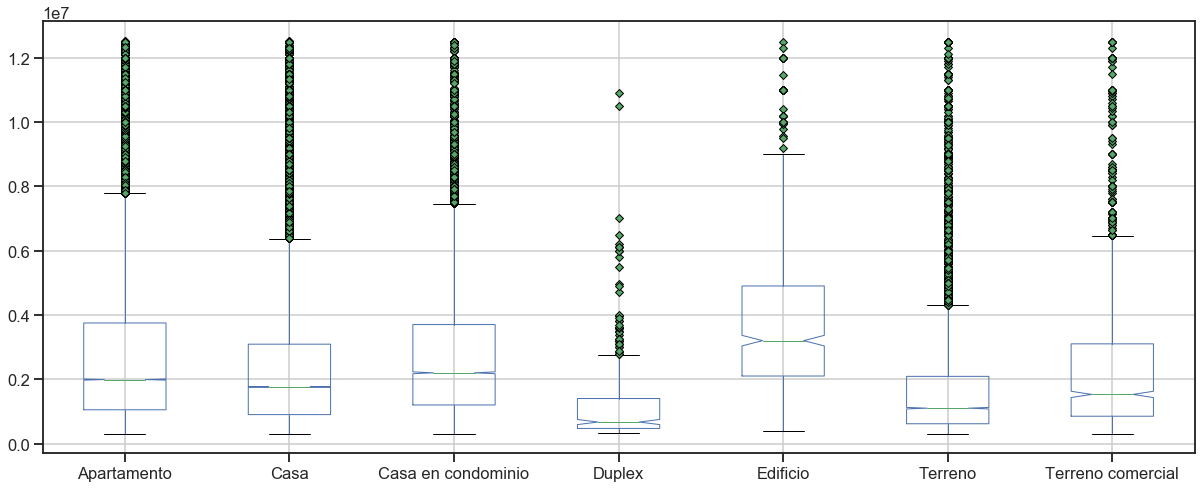

In [301]:
# Un boxplot ayuda a poder detectar estos outliers.
fig, ax = plt.subplots(figsize=(20,8))
green_diamond = dict(markerfacecolor='g', marker='D')
df_g1 = df[df['tipodepropiedad'].isin(['Casa','Apartamento','Edificio','Casa en condominio','Duplex','Terreno','Terreno comercial'])]
df_g1.boxplot(column='precio', by='tipodepropiedad', ax=ax, flierprops=green_diamond, notch=True)
ax.set_title('')
fig.suptitle('')
ax.set_xlabel('')
ax.set_ylabel('')

In [302]:
# Filtro los outliers, usando maximos y minimos en base al cuantil 1 y 3 y el IQR.
print('Despues de filtrar: ', df.shape)

def is_outlier(group):
    Q1 = group.quantile(0.25)
    Q3 = group.quantile(0.75)
    IQR = Q3 - Q1
    precio_min = Q1 - 1.5 * IQR
    precio_max = Q3 + 1.5 * IQR
    return ~group.between(precio_min, precio_max)

df = df[~df.groupby('tipodepropiedad')['precio'].apply(is_outlier)]

print('Despues de filtrar: ', df.shape)

Despues de filtrar:  (230036, 18)
Despues de filtrar:  (218827, 18)


Text(0, 0.5, '')

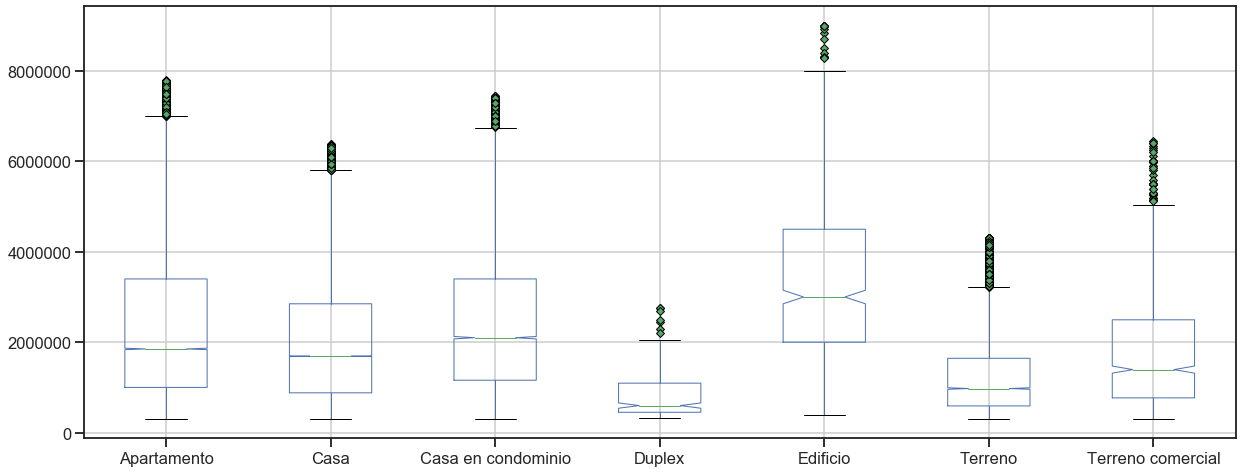

In [303]:
# Vuelvo a graficar, para ver como cambiaron los outliers.
fig, ax = plt.subplots(figsize=(20,8))
green_diamond = dict(markerfacecolor='g', marker='D')
df_small = df[df['tipodepropiedad'].isin(['Casa','Apartamento','Edificio','Casa en condominio','Duplex','Terreno','Terreno comercial'])]
df_small.boxplot(column='precio', by='tipodepropiedad', ax=ax, flierprops=green_diamond, notch=True)
ax.set_title('')
fig.suptitle('')
ax.set_xlabel('')
ax.set_ylabel('')

In [304]:
#Lleno los nulos de antiguedad con 0. Supongo que son todos nuevos.
df['antiguedad'].fillna(0, inplace=True)

# Quedaron solo 517 con antiguedad nula. Los reviso:
# df[df['antiguedad'].isnull()]

# Para estos restantes, tomo la decision de rellenarlos de acuerdo a el promedio de antiguedad segun el tipo de prop y la prov

# df['antiguedad'] = df.groupby(['tipodepropiedad','provincia'])['antiguedad'].transform(lambda x: x.fillna(x.mean()))

In [305]:
# df.isnull().sum()

In [306]:
# Los restantes, los elimino ya que son pocos y no puedo fijarle una antiguedad de forma tan directa
# df.dropna(subset=['antiguedad'], inplace=True)

In [307]:
df.isnull().sum()

titulo                        4868
descripcion                   1446
tipodepropiedad                  0
ciudad                           0
provincia                        0
antiguedad                       0
habitaciones                     0
garages                          0
banos                            0
metroscubiertos                  0
metrostotales                    0
fecha                            0
gimnasio                         0
usosmultiples                    0
piscina                          0
escuelascercanas                 0
centroscomercialescercanos       0
precio                           0
dtype: int64

In [308]:
# Hay 70000 filas en las que los metros totales son menores a los cubiertos. Esto es invalido. La realidad es que son muchas
# filas, por lo tano les seteo como metros totales, la misma cantidad que cubiertos.

df.loc[df['metrostotales']<df['metroscubiertos'], 'metrostotales'] = df['metroscubiertos']


In [309]:
# Aca deberia ir seteando las columnas nuevas que me parezcan utiles para analisis.
# Ideas: Precio por metro total, o agregar una columna con la cantidad de extras que tenga la casa.
df['precio_dolar'] = df['precio']/VALOR_CAMBIO_A_DOLAR
df['precio_m2'] = df['precio']/df['metrostotales']
df['extras'] = df['garages']+df['piscina']+df['usosmultiples']+df['gimnasio']


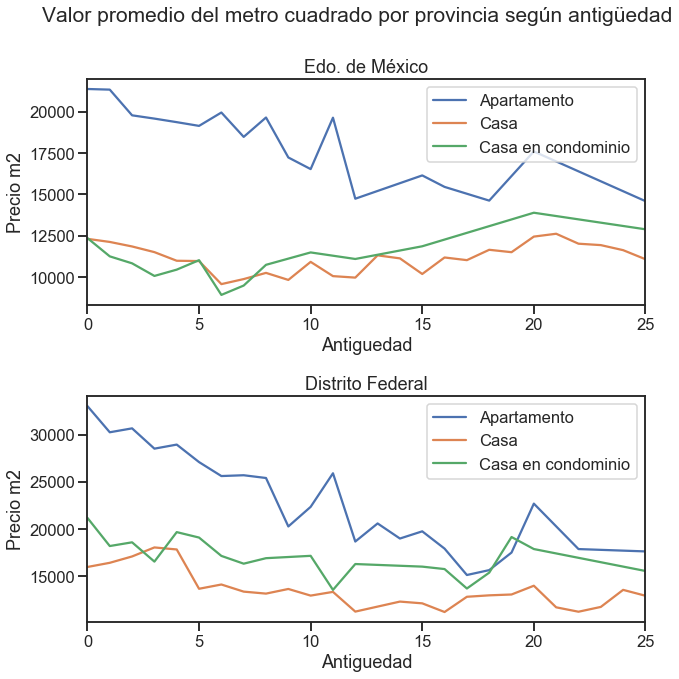

In [310]:
# Influye la antiguedad en el valor de las casas?
# Tomo datos agrupando por antiguedad, tipo de propiedad y provincia. 
# Filtro aquellos grupos donde la cantidad no es suficiente como para hacer un analisis consistente
# Armo un grafico para cada provincia, comparando los tipos de propiedad

df2 = df.copy()

df2 = df2[df2['extras']==2]

df2 = df2.groupby(['antiguedad','tipodepropiedad','provincia']).filter(lambda x: len(x)>10).groupby(['antiguedad','tipodepropiedad','provincia']).agg({'precio_m2':'mean'})

df2 = df2.reset_index()

fig,(ax1,ax2) = plt.subplots(2,1, figsize=(10,10))

fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.suptitle('Valor promedio del metro cuadrado por provincia según antigüedad',fontsize=21)

for name in ['Apartamento','Casa', 'Casa en condominio']:
    
    ax1.plot(df2[(df2.tipodepropiedad==name) & (df2.provincia == 'Edo. de México')].antiguedad,\
            df2[(df2.tipodepropiedad==name) & (df2.provincia == 'Edo. de México')].precio_m2,\
            label=name)
    ax1.set_title('Edo. de México')

    ax2.plot(df2[(df2.tipodepropiedad==name) & (df2.provincia == 'Distrito Federal')].antiguedad,\
            df2[(df2.tipodepropiedad==name) & (df2.provincia == 'Distrito Federal')].precio_m2,\
            label=name)
    ax2.set_title('Distrito Federal')

    ax1.set_xlim([0,25])
    ax2.set_xlim([0,25])

    
ax1.set_xlabel("Antiguedad")
ax1.set_ylabel("Precio m2")
ax1.legend(loc='best')
ax2.set_xlabel("Antiguedad")
ax2.set_ylabel("Precio m2")
ax2.legend(loc='best')

In [311]:
# Del grafico anterior, se puede observar:
# En ambas ciudades, los precios de los apartamentos van disminuyendo, a la vez que aumenta la antiguedad
# En el caso de las casas, los precios parecen no verse afectados por la antiguedad, pudiendo tener menos o mas valor
# La diferencia de precios, parece verse mas evidente a partir de los 10 años de antiguedad, no asi en los primeros 5.
# No es un dato menor que vaya disminuyendo pero a la vez siga habiendo picos. Si bien es un dato que influye,
# pueden existir casas mas antiguas de mayor valor.

In [312]:
# Caracteristicas principales de agrupar por habitaciones
# Las casas de mas habitaciones, son mucho mas viejas
# No es algo muy importante, pero es un dato curioso
df.groupby('habitaciones').mean()

,antiguedad,garages,banos,metroscubiertos,metrostotales,gimnasio,usosmultiples,piscina,escuelascercanas,centroscomercialescercanos,precio,precio_dolar,precio_m2,extras
habitaciones,,,,,,,,,,,,,,
0.00,0.00,0.00,0.00,40.00,40.00,0.00,0.00,0.00,0.00,0.00,500000.00,25588.54,12500.00,0.00
1.00,6.05,0.94,1.19,84.89,116.23,0.11,0.07,0.12,0.38,0.36,1680159.58,85985.65,20078.25,1.24
1.20,3.81,0.82,1.41,228.40,255.47,0.00,0.00,0.00,0.26,0.28,2098470.47,107393.58,12314.92,0.82
1.33,11.59,0.48,1.56,80.45,93.14,0.00,0.00,0.00,0.23,0.36,1656184.55,84758.68,28033.03,0.48
1.44,0.20,0.02,1.37,21.05,289.67,0.00,0.00,0.05,0.32,0.18,1039581.92,53202.76,10713.58,0.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8.00,13.90,1.24,2.62,270.51,285.86,0.01,0.01,0.03,0.42,0.34,2626539.20,134418.59,9897.65,1.29
8.25,21.00,1.08,2.90,303.80,307.00,0.00,0.00,0.00,0.40,0.40,3970000.00,203172.98,13476.04,1.08
9.00,15.10,1.28,2.46,277.85,294.61,0.01,0.02,0.01,0.40,0.37,2557393.56,130879.92,9639.35,1.32


In [313]:
# Cantidad de tipos de propiedades
df.tipodepropiedad.value_counts()

Casa                             129110
Apartamento                       53594
Casa en condominio                17719
Terreno                            9011
Local Comercial                    2570
Oficina comercial                  1555
Terreno comercial                  1190
Bodega comercial                   1046
Edificio                            686
Casa uso de suelo                   576
Quinta Vacacional                   372
Villa                               316
Duplex                              295
Rancho                              166
Inmuebles productivos urbanos       156
Local en centro comercial           148
Departamento Compartido             131
Otros                                82
Nave industrial                      61
Terreno industrial                   21
Huerta                               20
Hospedaje                             1
Garage                                1
Name: tipodepropiedad, dtype: int64

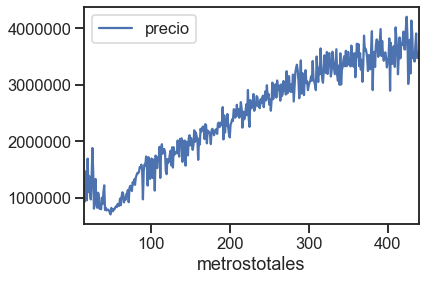

In [314]:
# Grafico muy sencillo como para ver como aumentan en conjunto precio y metrostotales
df.groupby('metrostotales').agg({'precio':'mean'}).plot()

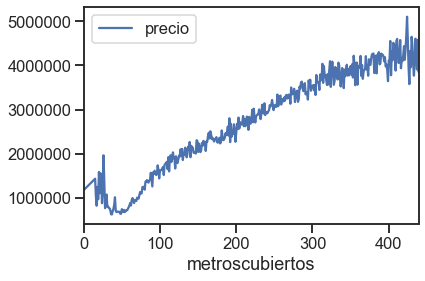

In [315]:
df.groupby('metroscubiertos').agg({'precio':'mean'}).plot()

In [316]:
# Valor de metro cuadrado por provincia y ciudad.
# Se podria hacer mucho mejor esto
df3 = df[df.piscina==0]
df3 = df[df.gimnasio==0]
df3 = df[df.antiguedad<5]
m2_x_zona = df3.groupby(['provincia','ciudad']).agg({'precio_m2':'mean'})
m2_x_zona

precio_m2
provincia      ciudad                        
Aguascalientes Aguascalientes         7447.33
               Asientos              10885.05
               El Llano               5000.00
               Jesús María            6950.02
               Pabellón de Arteaga    8382.53
...                                       ...
Zacatecas      Morelos                7940.20
               Río Grande             4457.36
               Villa de Cos           3322.78
               Villanueva             3869.05
               Zacatecas              6561.49

[738 rows x 1 columns]

In [317]:
# Provincias mas grandes
df.groupby(['ciudad']).size().sort_values()[-10:]

ciudad
Atizapán de Zaragoza     5033
Alvaro Obregón           5231
Naucalpan de Juárez      5464
Cuauhtémoc               5820
Monterrey                6178
Mérida                   6832
San Luis Potosí          7163
Zapopan                  9490
Benito Juárez           10058
Querétaro               12116
dtype: int64

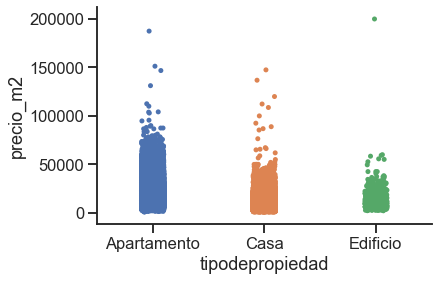

In [318]:
sns.set(style='ticks', context='talk')

sns.stripplot(x='tipodepropiedad', y='precio_m2', data=df, order=['Apartamento','Casa','Edificio'], jitter=True)
sns.despine()